# Homework 4

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [140]:
df = pd.read_csv('data.csv')

In [141]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [143]:
df.describe()

,number_of_courses_viewed,annual_income,interaction_count,lead_score,converted
count,1462.000000,1281.000000,1462.000000,1462.000000,1462.000000
mean,2.031464,59886.273224,2.976744,0.506108,0.619015
std,1.449717,15070.140389,1.681564,0.288465,0.485795
min,0.000000,13929.000000,0.000000,0.000000,0.000000
25%,1.000000,49698.000000,2.000000,0.262500,0.000000
50%,2.000000,60148.000000,3.000000,0.510000,1.000000
75%,3.000000,69639.000000,4.000000,0.750000,1.000000
max,9.000000,109899.000000,11.000000,1.000000,1.000000


In [144]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [145]:
if df.isnull().values.any():
    categorical_cols = df.select_dtypes(include=['object']).columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    
    df[categorical_cols] = df[categorical_cols].fillna('NA')
    df[numerical_cols] = df[numerical_cols].fillna(0.0)

In [146]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [147]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

## Question 1

In [148]:
from sklearn.metrics import roc_auc_score

features = [
    'lead_score',
    'number_of_courses_viewed',
    'interaction_count',
    'annual_income'
]
scores = {}

y_train = df_train['converted']

for feature in features:
    values = df_train[feature]
    auc = roc_auc_score(y_train, values)
    if auc < 0.5:
        auc = roc_auc_score(y_train, -values)
    scores[feature] = auc

for feature, auc in sorted(scores.items(), key=lambda x: -x[1]):
    print(f"{feature}: {auc:.3f}")

number_of_courses_viewed: 0.764
interaction_count: 0.738
lead_score: 0.614
annual_income: 0.552


## Question 2

In [149]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

features = ['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income', 'employment_status', 'location', 'interaction_count', 'lead_score']

df_train_copy = df_train[features].fillna('NA')
df_val_copy = df_val[features].fillna('NA')

for col in ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']:
    df_train_copy[col] = df_train_copy[col].replace('NA', 0).astype(float)
    df_val_copy[col] = df_val_copy[col].replace('NA', 0).astype(float)

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(df_train_copy.to_dict(orient='records'))
X_val = dv.transform(df_val_copy.to_dict(orient='records'))

y_train = df_train['converted'].values
y_val = df_val['converted'].values

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, val_pred)
print(f"AUC on validation: {auc:.3f}")


AUC on validation: 0.817


## Question 3

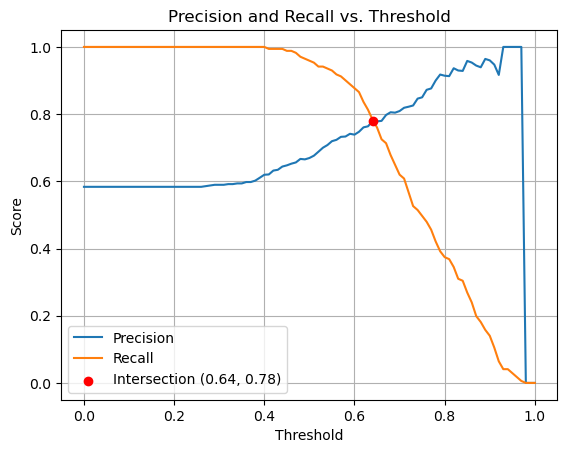

In [150]:
from sklearn.metrics import precision_score, recall_score

thresholds = np.arange(0.0, 1.01, 0.01)
precision = []
recall = []

for t in thresholds:
    preds = (val_pred >= t).astype(int)
    precision.append(precision_score(y_val, preds, zero_division=0))
    recall.append(recall_score(y_val, preds))

precision = np.array(precision)
recall = np.array(recall)
search_mask = (thresholds >= 0.4) & (thresholds <= 0.8)
diff = np.abs(precision - recall)
search_diff = diff[search_mask]
search_thresholds = thresholds[search_mask]

ix_in_search = np.argmin(search_diff)
ix = np.where(search_mask)[0][ix_in_search]

intersect_threshold = thresholds[ix]
intersect_value = precision[ix]

plt.figure()
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, recall, label='Recall')
plt.scatter([intersect_threshold], [intersect_value], color='red', zorder=5, label=f'Intersection ({intersect_threshold:.2f}, {intersect_value:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()


## Question 4

In [151]:
f1_scores = []

for p, r in zip(precision, recall):
    if p + r == 0:
        f1 = 0
    else:
        f1 = 2 * p * r / (p + r)
    f1_scores.append(f1)

max_f1 = max(f1_scores)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f'Maximum F1 score: {max_f1:.3f} at threshold: {best_threshold:.2f}')


Maximum F1 score: 0.812 at threshold: 0.57


## Question 5

In [152]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []

for train_idx, val_idx in kf.split(df_full_train):
    X_train = df_full_train.iloc[train_idx].drop('converted', axis=1)
    y_train = df_full_train.iloc[train_idx]['converted']
    X_val = df_full_train.iloc[val_idx].drop('converted', axis=1)
    y_val = df_full_train.iloc[val_idx]['converted']
    
    X_train = pd.get_dummies(X_train)
    X_val = pd.get_dummies(X_val)
    X_train, X_val = X_train.align(X_val, join='left', axis=1, fill_value=0)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    val_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, val_pred)
    auc_scores.append(auc)

print('AUC scores for each fold:', auc_scores)
print('Standard deviation of AUC scores: %.5f' % np.std(auc_scores))


AUC scores for each fold: [0.8060745924216483, 0.8713738368910783, 0.7754320118852139, 0.8018368617683685, 0.8558272713202291]
Standard deviation of AUC scores: 0.03581


## Question 6

In [153]:

C_values = [0.000001, 0.001, 1]
scores_summary = []

for C in C_values:
    auc_scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    for train_idx, val_idx in kf.split(df_full_train):
        X_train = df_full_train.iloc[train_idx].drop('converted', axis=1)
        y_train = df_full_train.iloc[train_idx]['converted']
        X_val = df_full_train.iloc[val_idx].drop('converted', axis=1)
        y_val = df_full_train.iloc[val_idx]['converted']
        
        X_train = pd.get_dummies(X_train)
        X_val = pd.get_dummies(X_val)
        X_train, X_val = X_train.align(X_val, join='left', axis=1, fill_value=0)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)
        val_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, val_pred)
        auc_scores.append(auc)
    
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    scores_summary.append((C, mean_auc, std_auc))
    print(f'C={C}: mean AUC={mean_auc:.3f}  std={std_auc:.3f}')

scores_summary = sorted(scores_summary, key=lambda x: (-round(x[1],3), round(x[2],3), x[0]))
best_C = scores_summary[0][0]
print(f'Best C: {best_C}')


C=1e-06: mean AUC=0.560  std=0.024
C=0.001: mean AUC=0.867  std=0.029
C=1: mean AUC=0.822  std=0.036
Best C: 0.001
